In [1]:
!pip install transformers datasets numpy


     ---------------------------------------- 0.0/134.8 kB ? eta -:--:--
     -------- ------------------------------ 30.7/134.8 kB 1.3 MB/s eta 0:00:01
     -------------------------------------- 134.8/134.8 kB 2.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/8.8 MB ? eta -:--:--
    --------------------------------------- 0.1/8.8 MB 2.8 MB/s eta 0:00:04
   - -------------------------------------- 0.4/8.8 MB 3.8 MB/s eta 0:00:03
   -- ------------------------------------- 0.5/8.8 MB 3.9 MB/s eta 0:00:03
   -- ------------------------------------- 0.7/8.8 MB 3.4 MB/s eta 0:00:03
   --- ------------------------------------ 0.8/8.8 MB 3.4 MB/s eta 0:00:03
   ---- ----------------------------------- 1.0/8.8 MB 3.6 MB/s eta 0:00:03
   ----- ---------------------------------- 1.2/8.8 MB 3.7 MB/s eta 0:00:03
   ----- ---------------------------------- 1.3/8.8 MB 3.6 MB/s eta 0:00:03
   ------ --------------------------------- 1.5/8.8 MB 3.6 MB/s eta 0:00:03
   ------- ---

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.17.2 requires torch==2.2.2, but you have torch 2.2.0+cu118 which is incompatible.


In [8]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk(r'C:\Users\insid\OneDrive\Desktop\Project DL'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


C:\Users\insid\OneDrive\Desktop\Project DL\bert.ipynb
C:\Users\insid\OneDrive\Desktop\Project DL\exp custom.ipynb
C:\Users\insid\OneDrive\Desktop\Project DL\exp-cnn-lstm.ipynb
C:\Users\insid\OneDrive\Desktop\Project DL\exp-lstm.ipynb
C:\Users\insid\OneDrive\Desktop\Project DL\IMDB Dataset.csv
C:\Users\insid\OneDrive\Desktop\Project DL\sentiment-analysis-using-lstm-pytorch.ipynb
C:\Users\insid\OneDrive\Desktop\Project DL\visualization.ipynb


In [18]:
!pip install accelerate>=0.21.0

In [16]:
!pip install transformers[torch]

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt


imdb_dataset = pd.read_csv(r"C:\Users\insid\OneDrive\Desktop\Project DL\IMDB Dataset.csv")


tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")


def tokenize_function(text):
    return tokenizer(text, padding=True, truncation=True, max_length=512)


texts = imdb_dataset['review'].tolist()
labels = imdb_dataset['sentiment'].map({'positive': 1, 'negative': 0}).tolist()


train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.1, random_state=42)


train_encodings = tokenize_function(train_texts)
test_encodings = tokenize_function(test_texts)
val_encodings = tokenize_function(val_texts)


train_dataset = TensorDataset(
    torch.tensor(train_encodings['input_ids']),
    torch.tensor(train_encodings['attention_mask']),
    torch.tensor(train_labels)
)
test_dataset = TensorDataset(
    torch.tensor(test_encodings['input_ids']),
    torch.tensor(test_encodings['attention_mask']),
    torch.tensor(test_labels)
)
val_dataset = TensorDataset(
    torch.tensor(val_encodings['input_ids']),
    torch.tensor(val_encodings['attention_mask']),
    torch.tensor(val_labels)
)


train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)
val_loader = DataLoader(val_dataset, batch_size=64)


criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)




In [23]:

num_epochs = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def evaluate(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in data_loader:
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            _, predicted = torch.max(outputs.logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

Epoch 1/3 - Train Acc: 0.9861, Test Acc: 0.9488, Val Acc: 0.9497
Epoch 2/3 - Train Acc: 0.9940, Test Acc: 0.9504, Val Acc: 0.9493
Epoch 3/3 - Train Acc: 0.9972, Test Acc: 0.9494, Val Acc: 0.9493


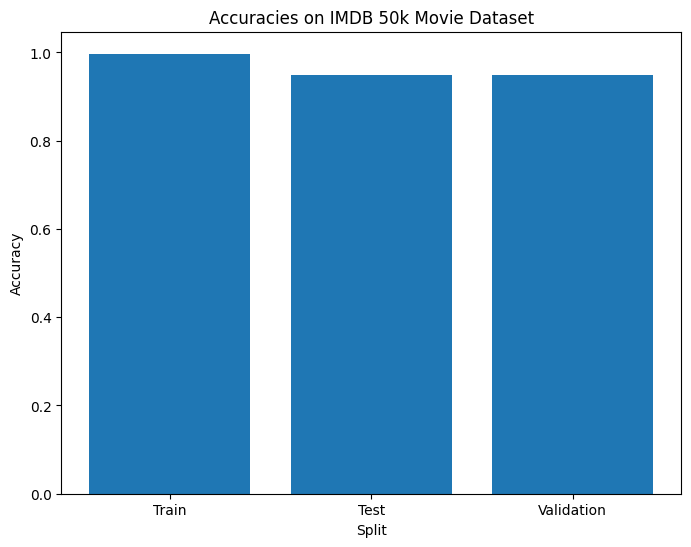

In [24]:

for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    model.eval()
    train_accuracy = evaluate(model, train_loader, device)
    test_accuracy = evaluate(model, test_loader, device)
    val_accuracy = evaluate(model, val_loader, device)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")





labels = ['Train', 'Test', 'Validation']
accuracies = [train_accuracy, test_accuracy, val_accuracy]

plt.figure(figsize=(8, 6))
plt.bar(labels, accuracies)
plt.xlabel('Split')
plt.ylabel('Accuracy')
plt.title('Accuracies on IMDB 50k Movie Dataset')
plt.show()

In [65]:



def predict_sentiments(statements):
    tokenized_statements = tokenize_function(statements)
    input_ids = torch.tensor(tokenized_statements['input_ids']).to(device)
    attention_mask = torch.tensor(tokenized_statements['attention_mask']).to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_labels = torch.argmax(logits, dim=1).cpu().tolist()
    print(predicted_labels)
    sentiment_map = {0: 'negative', 1: 'neutral',2:"positive"}
    predicted_sentiments = []
    for label in predicted_labels:
        if label in sentiment_map:
            predicted_sentiments.append(sentiment_map[label])
        else:
            predicted_sentiments.append('unknown')

    return predicted_sentiments


statements_to_predict = [
    "This movie was absolutely fantastic!",
    "I didn't enjoy the film at all. It was boring and predictable.",
    "The acting was great, but the story was lacking.",
    "I absolutely loved this song! It's catchy and the lyrics are meaningful."
]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)  

predicted_sentiments = predict_sentiments(statements_to_predict)

for statement, sentiment in zip(statements_to_predict, predicted_sentiments):
    print(f"Statement: {statement}")
    print(f"Predicted Sentiment: {sentiment}")
    print()

[2, 0, 1, 2]
Statement: This movie was absolutely fantastic!
Predicted Sentiment: positive

Statement: I didn't enjoy the film at all. It was boring and predictable.
Predicted Sentiment: negative

Statement: The acting was great, but the story was lacking.
Predicted Sentiment: neutral

Statement: I absolutely loved this song! It's catchy and the lyrics are meaningful.
Predicted Sentiment: positive

